## Исследование накрутки кликов

Данный проект имеет цель проанализировать пользовательскую активность, чтобы вычислить, какие сигналы свидетельствуют о "накрученных кликах".

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r'C:\Users\Ксюша\OneDrive\Рабочий стол\Работа\Python projects\Анжелика_фейк клики\test_data.tsv', sep='\t')
df

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash
0,347854231724,1050848,21,0,3818162082,8335634595980108828,2,2,1642713892,1732823002,17261330804588317013,16521739535555380904
1,329455126064,694606,36,0,3818162082,2563013194488493467,3,2,2286540757,673473971,8781226038565509786,14273372146021722044
2,329455254926,694659,36,0,3818162082,2563013194488493467,3,2,2286540757,673473971,8781226038565509786,14273372146021722044
3,329455273798,694596,36,0,3818162082,2563013194488493467,3,2,3529439892,673473971,8781226038565509786,14273372146021722044
4,329455293738,694608,36,0,3818162082,2563013194488493467,3,2,390304810,673473971,8781226038565509786,14273372146021722044
...,...,...,...,...,...,...,...,...,...,...,...,...
48667,18633226968,447584,99968,0,239476928,13342788246879828416,2,2,390304810,673473971,1832022913681533286,20031587159191549
48668,315935247147,413686,99983,0,3661556033,7178601307473141660,2,2,3529439892,2854608146,3496401290695810857,18435015251755828519
48669,323106573203,557494,99995,0,2960729952,15043720182730569642,3,2,3529439892,673473971,17190617809738632834,17743323135665871600
48670,323106589352,557496,99995,0,2960729952,15043720182730569642,3,2,3529439892,673473971,17190617809738632834,17743323135665871600


# 1. Анализ CTR (конверсия показов в клики)

Сначала я решила посчитать показатель CTR, сгруппировав по пользователям, регионам, ID-каналу поставщика и IP-сетям. Данный показатель расчитан как отношение числа кликов (сагрегировали tn по сумме, сложив единицы - клики) к числу показов (посчитали кол-во строк, так как клик - это тоже показ, просто пользователь перешел по баннеру)

In [3]:
ctr_by_user = df.groupby('user')['tn'].agg(['sum', 'count']).reset_index()
ctr_by_user.columns = ['user', 'clicks', 'impressions']
ctr_by_user['CTR'] = ctr_by_user['clicks'] / ctr_by_user['impressions']

ctr_by_geo = df.groupby('geo')['tn'].agg(['sum', 'count']).reset_index()
ctr_by_geo.columns = ['geo', 'clicks', 'impressions']
ctr_by_geo['CTR'] = ctr_by_geo['clicks'] / ctr_by_geo['impressions']

ctr_by_site = df.groupby('siteid')['tn'].agg(['sum', 'count']).reset_index()
ctr_by_site.columns = ['siteid', 'clicks', 'impressions']
ctr_by_site['CTR'] = ctr_by_site['clicks'] / ctr_by_site['impressions']

ctr_by_cnethash = df.groupby('cnethash')['tn'].agg(['sum', 'count']).reset_index()
ctr_by_cnethash.columns = ['cnethash', 'clicks', 'impressions']
ctr_by_cnethash['CTR'] = ctr_by_cnethash['clicks'] / ctr_by_cnethash['impressions']

Я написала функцию, которая высчитывает выбросы (аномальные значения) методом 1.5 интерквартильного расстояния и возвращает датафрейм, содержащий выбросы

In [4]:
def outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

Применяю функцию к датафреймам, где подсчитывали CTR

In [5]:
outliers_user = outliers(ctr_by_user, 'CTR')
outliers_geo = outliers(ctr_by_geo, 'CTR')
outliers_site = outliers(ctr_by_site, 'CTR')
outliers_cnethash = outliers(ctr_by_cnethash, 'CTR')

In [6]:
outliers_user

,user,clicks,impressions,CTR
7,207,1,3,0.333333
15,363,3,24,0.125000
41,920,1,15,0.066667
60,1242,1,27,0.037037
69,1435,1,2,0.500000
...,...,...,...,...
4372,99209,1,1,1.000000
4381,99318,2,34,0.058824
4382,99334,1,8,0.125000
4405,99649,1,2,0.500000


In [7]:
outliers_geo

,geo,clicks,impressions,CTR
19,1260189617,3,17,0.176471
51,2972730849,3,15,0.200000
58,3330446895,11,110,0.100000


In [8]:
outliers_site

,siteid,clicks,impressions,CTR


In [9]:
outliers_cnethash

,cnethash,clicks,impressions,CTR
21,92744374916772577,2,5,0.400000
27,130491373923111892,10,141,0.070922
36,177837659435772559,2,19,0.105263
38,181591858194946818,1,49,0.020408
42,196654785114284251,1,8,0.125000
...,...,...,...,...
2990,18307009223832056658,3,69,0.043478
2995,18333695586270196459,11,225,0.048889
2997,18357792100663126727,1,10,0.100000
3006,18413296758687092037,3,18,0.166667


Добавляю визуализацию, чтобы было наглядно видно аномальные значения по CTR

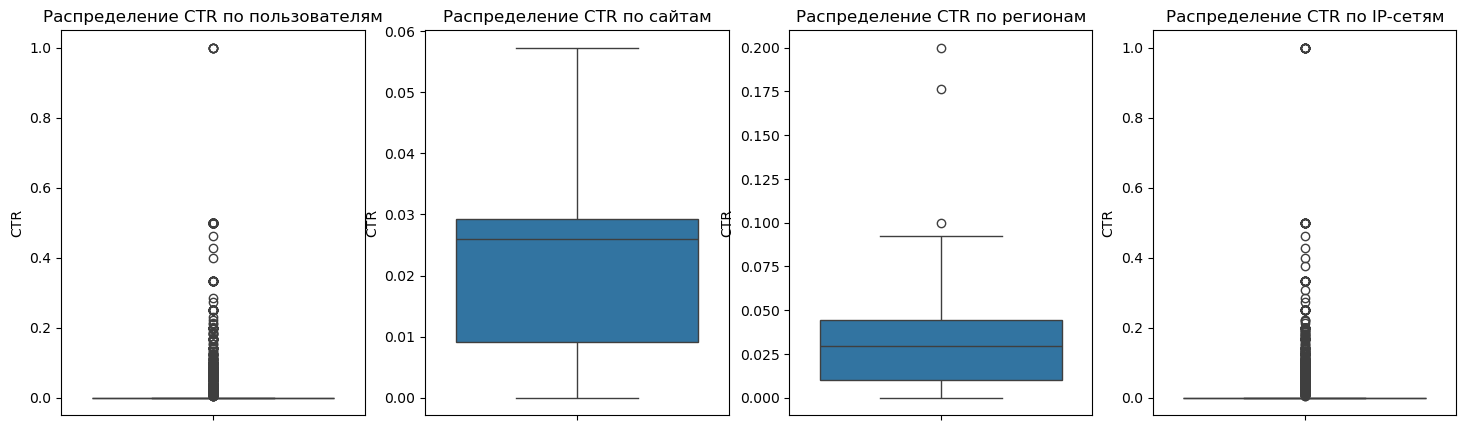

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
sns.boxplot(y=ctr_by_user['CTR'], ax=axes[0])
axes[0].set_title('Распределение CTR по пользователям')

sns.boxplot(y=ctr_by_site['CTR'], ax=axes[1])
axes[1].set_title('Распределение CTR по сайтам')

sns.boxplot(y=ctr_by_geo['CTR'], ax=axes[2])
axes[2].set_title('Распределение CTR по регионам')

sns.boxplot(y=ctr_by_cnethash['CTR'], ax=axes[3])
axes[3].set_title('Распределение CTR по IP-сетям')

plt.show()

Видно, что больше всего выбросов по CTR наблюдается по пользователям и по IP-сетям, по сайту отсутсвуют выбросы

**ВЫВОД:**
* У 379 пользователей обнаружен аномально высокий CTR
* Есть регионы и сети с необычно высоким CTR (мошенничество могло исходить из определённых IP-сетей)

# 2. Анализ количества кликов на пользователя

Также я решила посчитать, сколько пользователей совершило наибольшее кол-во кликов

Использую метод межквартильного размаха (IQR), как и в анализе CTR

In [11]:
clicks_per_user = df[df['tn'] == 1].groupby('user')['tn'].count().reset_index().rename(columns={'tn': 'clicks'})
outliers_clicks = outliers(clicks_per_user, 'clicks')

In [12]:
outliers_clicks

,user,clicks
7,1636,13
13,3443,13
14,4016,34
19,5253,10
22,5999,16
24,6886,13
30,8665,11
31,9471,28
52,15400,22
60,16618,32


**ВЫВОД:**
* 53 пользователя совершили чрезмерное количество кликов

# 3. Анализ частоты кликов во времени

Я решила провести анализ частоты кликов
* Вычислила разницу во времени между событиями (t_diff)
* Посчитала количество кликов в секунду (clicks_per_sec)

Если пользователь кликает слишком быстро, то возможно, что это накрутка

In [13]:
df['t_diff'] = df['t'].diff().fillna(1)
df['clicks_per_sec'] = df['tn'] / df['t_diff']
outliers_click_speed = outliers(df, 'clicks_per_sec')

In [14]:
outliers_click_speed

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash,t_diff,clicks_per_sec
15,299522852624,72336,207,1,1539789858,1914105787300337336,2,2,3529439892,1732823002,6914246990831417846,7225540168013982636,63.0,0.015873
29,48923341882,1135684,363,1,496411576,618208581979777446,2,2,3529439892,1732823002,7589661441840127586,13552381492480484636,15.0,0.066667
31,48925603446,1135717,363,1,496411576,618208581979777446,2,2,3529439892,1732823002,7589661441840127586,13552381492480484636,11.0,0.090909
42,52173416312,1208840,363,1,496411576,618208581979777446,2,2,4059410016,1732823002,5398870908427309388,7145879351273368377,4.0,0.250000
93,16010841443,376051,920,1,390304810,2339536559139938629,2,2,2286540757,673473971,15630579387847758071,15271819797260967753,14.0,0.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48553,15879594241,373660,99318,1,1930118761,7585879360314672366,2,2,3529439892,2854608146,12589694513104196708,4064347458369280212,11.0,0.090909
48559,16203440514,379349,99318,1,1930118761,7585879360314672366,2,2,3529439892,2854608146,14587862015958063696,3666124054315925662,6.0,0.166667
48567,11601204597,276134,99334,1,3255688796,3386656292732252881,2,2,3529439892,3312146801,1461826196852647864,17388631505828371636,6.0,0.166667
48637,1987722430,40576,99649,1,2169085419,16112456752452597717,2,2,4059410016,1732823002,17566469994103955311,16564149921968231291,20.0,0.050000


**ВЫВОД:**
* 1547 событий характеризуются аномально высокой частотой кликов

# Заключение

Критериями определения накрутки стали:

* Высокий CTR (аномально большое количество кликов на один показ)
* Чрезмерное количество кликов у пользователя (неестественная активность)
* Высокая частота кликов (поведение, похожее на поведение ботов)

Использование всех трёх метрик позволяет уверенно определить подозрительную активность